In [1]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [2]:
def MarkedElementList(marked_list,number_of_qubits):
    oracle_list = [1]*(2**number_of_qubits)
    for element in marked_list:
        oracle_list[element]=-1
    return oracle_list

def OracleCircuit(oracle_list,number_of_qubits):
    qreg = QuantumRegister(number_of_qubits)
    qc_oracle = QuantumCircuit(qreg,name='Grover Oracle')
    qc_oracle.diagonal(oracle_list,qreg)
    return qc_oracle

def DiffusionCircuit(number_of_qubits):
    qreg = QuantumRegister(number_of_qubits)
    qc_diffusion = QuantumCircuit(qreg,name='Grover Diffusion')
    qc_diffusion.h(range(number_of_qubits))
    #----
    aux_list = MarkedElementList([0],number_of_qubits)
    qc_aux = OracleCircuit(aux_list,number_of_qubits)
    qc_diffusion.append(qc_aux,range(number_of_qubits))
    #---
    qc_diffusion.h(range(number_of_qubits))
    return qc_diffusion

def GroverCircuit(qc_oracle,qc_diffusion,number_of_qubits,steps):
    qc_grover = QuantumCircuit(number_of_qubits,number_of_qubits)
    qc_grover.h(range(number_of_qubits))
    for t in range(steps):
        qc_grover.append(qc_oracle,range(number_of_qubits))
        qc_grover.append(qc_diffusion,range(number_of_qubits))
    qc_grover = transpile(qc_grover,basis_gates=['cx','u3'],optimization_level=3)
    qc_grover.barrier()
    qc_grover.measure(range(number_of_qubits),range(number_of_qubits))
    return qc_grover

def QasmRunning(qc_grover):
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc_grover,backend).result().get_counts()
    return result

#--- running on real backends
def RealRunning(qc_grover,backend_str):
    IBMQ.load_account()
    provider = IBMQ.get_provider(group='open')
    backend = provider.get_backend(backend_str)
    job = execute(qc_grover, backend=backend)
    display(job_monitor(job))
    result = job.result().get_counts()
    return result

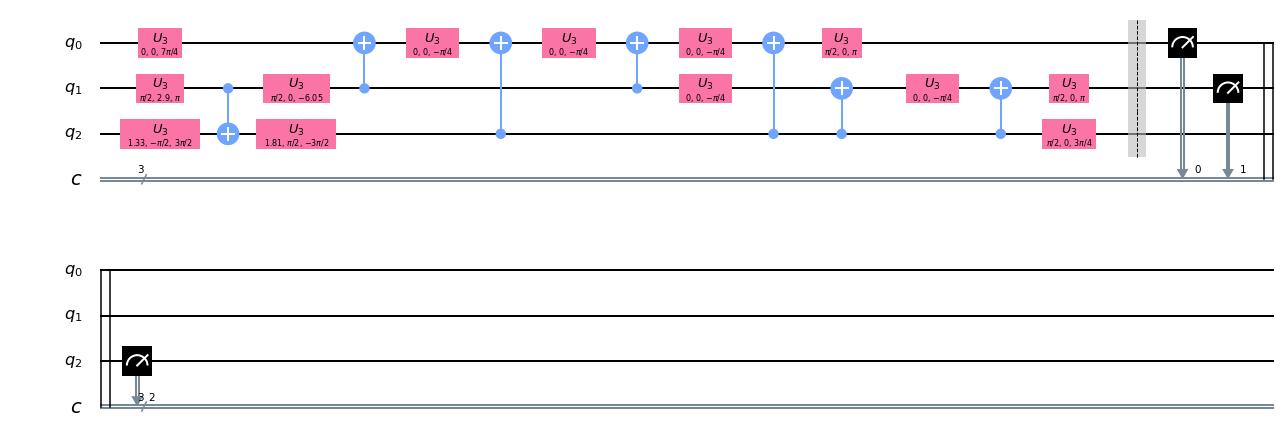

In [3]:
#-- setting up
marked_list = [0,1]
number_of_qubits = 3
steps=1
#-- creating the circuit
oracle_list = MarkedElementList(marked_list,number_of_qubits)
qc_oracle = OracleCircuit(oracle_list,number_of_qubits)
qc_diffusion = DiffusionCircuit(number_of_qubits)
qc_grover = GroverCircuit(qc_oracle,qc_diffusion,number_of_qubits,steps)
#-- plotting circuit
qc_grover.draw()

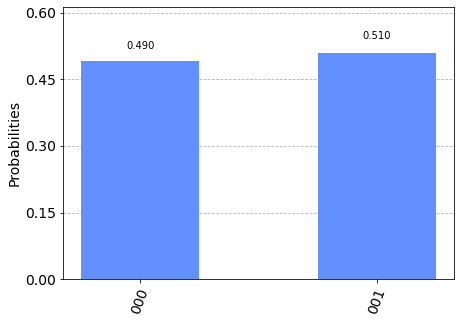

In [4]:
#--- running the circuit with qasm simulator
result_qasm = QasmRunning(qc_grover)
plot_histogram(result_qasm)

Job Status: job has successfully run


None

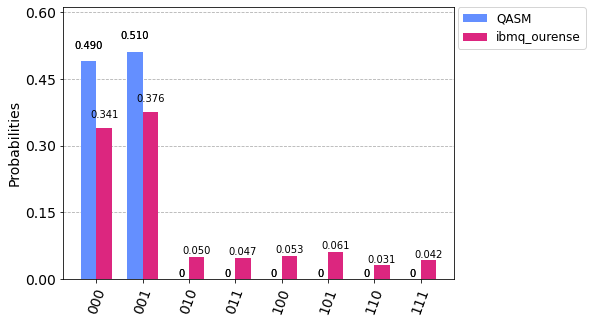

In [5]:
#--- running on real backends
ibm_backend = 'ibmq_ourense'
result_ibm = RealRunning(qc_grover,ibm_backend)
#-- compared results
legend = ['QASM',ibm_backend]
plot_histogram([result_qasm,result_ibm], legend=legend)